In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy import interpolate
from tenet.util import sphMap
import scipy.stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.optimize import curve_fit
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib inline

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)

os.chdir('/u/reric/Scripts/')
! pwd


/vera/u/reric/Scripts


In [2]:
# define some plotting parameters
figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

outdirec_figures = '/u/reric/Figures/ColdPast/TNG-Cluster/'
outdirec_overleaf = '/u/reric/Papers/Rohretal_TNG_CoolerPast/figures/'
outdirecs = [outdirec_figures, outdirec_overleaf]
savefig = False

In [3]:
sim = 'TNG-Cluster'
basePath = ru.ret_basePath(sim)
gas_ptn = 0
redshift = 4.
snapNum = 21
haloID =  14131544
header = ru.loadHeader(basePath, snapNum)

h = header['HubbleParam']
a = header['Time']
boxsize = header['BoxSize'] * a / h

mass_hilim = 1.0e8
boxsizeimg = 3. # r200c
depth = 3.0 # r200c
nPixels = 1024
gas_hsml_fact = 1.5
axes = [0,1]


In [4]:

halo = il.groupcat.loadSingle(basePath, snapNum, haloID=haloID)
HaloPos = halo['GroupPos'] * a / h
R200c = halo['Group_R_Crit200'] * a / h

_gas_cells = il.snapshot.loadOriginalZoom(basePath, snapNum, haloID, gas_ptn)
_gas_cells = ru.calc_temp_dict(_gas_cells)

Masses = _gas_cells['Masses'] * 1.0e10 / h
_Coordinates = _gas_cells['Coordinates'] * a / h
Coordinates = ru.shift(_Coordinates, HaloPos, boxsize)


In [5]:
mass_mask = Masses < 1.0e8
depth_mask = np.abs(Coordinates[:,2]) < (depth * R200c / 2.)
mask = mass_mask & depth_mask

gas_cells = {}
for key in _gas_cells:
    if key == 'count':
        gas_cells[key] = mask[mask].size
    else:
        gas_cells[key] = _gas_cells[key][mask].copy()



In [6]:
Masses = gas_cells['Masses'] * 1.0e10 / h
Coordinates = gas_cells['Coordinates'] * a / h
Densities = gas_cells['Density'] * 1.0e10 / h / (a / h)**3
Sizes = (Masses / (Densities * 4./3. * np.pi))**(1./3.) * gas_hsml_fact

pos = Coordinates[:,axes]
hsml = Sizes
mass = Masses
boxSizeImg = [boxsizeimg*R200c, boxsizeimg*R200c] # kpc
boxSizeSim = [boxsize, boxsize, boxsize]
boxCen = HaloPos[axes]    
ndims = 3
colDens = False
quant = np.log10(gas_cells['Temperature'])

result = sphMap.sphMap(pos, hsml, mass, quant, [0,1], boxSizeImg, boxSizeSim, boxCen, [nPixels, nPixels], ndims, colDens=colDens)


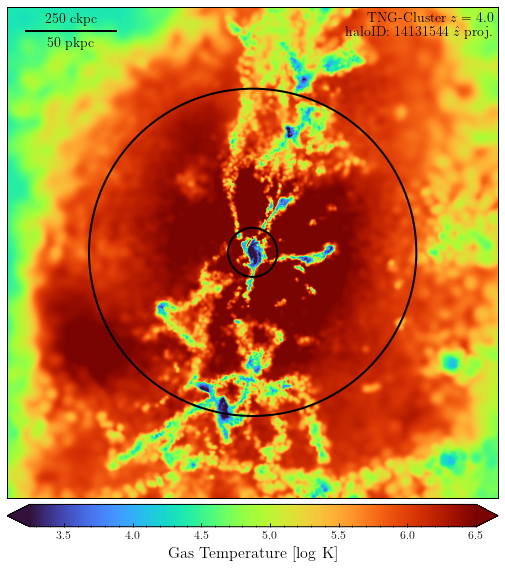

In [7]:
fig, ax = plt.subplots(figsize=(figsizewidth, figsizewidth*1.15))

extent = [-boxSizeImg[0]/2., boxSizeImg[0]/2., -boxSizeImg[0]/2., boxSizeImg[0]/2.]
length = 50 #pkpc

imshow_kwargs = dict(cmap='turbo', norm=mpl.colors.Normalize(vmin=3.25, vmax=6.5),
                     origin='lower', extent=extent)
img = ax.imshow(result, **imshow_kwargs)

ax.set_xticks([])
ax.set_yticks([])

color='black'
circ_kwargs = dict(color=color, fill=False, lw=2)
circle_r200c = plt.Circle((0., 0.), R200c, **circ_kwargs)
ax.add_patch(circle_r200c)
circle_015r200c = plt.Circle((0., 0.), 0.15*R200c, **circ_kwargs)
ax.add_patch(circle_015r200c)

x0 = -boxSizeImg[0]/2. + (boxSizeImg[0]/2. * 0.075)# kpc
y0 = boxSizeImg[0]/2. -(boxSizeImg[0]/2. * 0.1)# kpc
ax.plot([x0, x0+length], [y0, y0], color=color, marker='None', ls='-')
text_kwargs = dict(fontsize=14, color=color)
ax.text(x0+length/2., y0-(boxSizeImg[0]/2. * 0.025), '%d pkpc'%(int(length)), ha='center', va='top', **text_kwargs)
ax.text(x0+length/2., y0+(boxSizeImg[0]/2. * 0.025), '%d ckpc'%(int(round(length / a))), ha='center', va='bottom', **text_kwargs)

text = (r'TNG-Cluster $z=%.1f$'%redshift + '\n'
        'haloID: %d '%haloID + r'$\hat{z}$ proj.')
ax.text(.99, 0.99, text, ha='right', va='top', ma='right', transform=ax.transAxes, **text_kwargs)

# add colorbar 
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', label=r'Gas Temperature [log K]', extend='both', pad=0.01)
cbar.set_label(r'Gas Temperature [log K]', fontsize=16)
cbar.ax.tick_params('both', labelsize=12)

fname = 'TNG-Cluster_snapNum%03d_haloID%08d_TemperatureMap.pdf'%(snapNum, haloID)
if savefig:
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', dpi=300)

### moving on

In [8]:
snapNums = [99, 67, 33, 21]
SnapNums = np.arange(99, -1, -1)
indices = np.zeros(len(snapNums), dtype=int) - 1
for snapNum_i, snapNum in enumerate(snapNums):
    indices[snapNum_i] = np.where(snapNum == SnapNums)[0]

In [9]:
haloIDs = [6913365, 18685064, 13737849, 6834499, 1431487]
GroupFirstSubs = il.groupcat.loadHalos(basePath, 99, fields='GroupFirstSub')
subhaloIDs = GroupFirstSubs[haloIDs]
grp_keys = []
for subhaloID in subhaloIDs:
    grp_keys.append('%03d_%08d'%(99, subhaloID))


In [10]:

def load_grpdict(infname, sim='L680n8192TNG', grp_keys=None, dset_keys=None):
    result = {}
    with h5py.File('../Output/%s_subfindGRP/'%sim + infname, 'r') as f:
        if not grp_keys:
            grp_keys = list(f.keys())
        for group_key_i, group_key in enumerate(grp_keys):
            result[group_key] = {}
            if group_key_i == 0:
                SnapNums = f[group_key]['SnapNum'][:]
                snapNums = [99, 67, 33, 21]
                indices = np.zeros(len(snapNums), dtype=int) - 1
                for snapNum_i, snapNum in enumerate(snapNums):
                    indices[snapNum_i] = np.where(snapNum == SnapNums)[0]
            if not dset_keys:
                dset_keys = f[group_key].keys()
            for dset_key in dset_keys:
                result[group_key][dset_key] = f[group_key][dset_key][indices]
        f.close()
    
    return result

sim = 'L680n8192TNG'
infname = 'central_groups_subfind_L680n8192TNG_branches.hdf5'
maps_keys = ['CoolGasSurfaceDensityMap', 'SFRSurfaceDensityMap', 'MgiiColDensMap_depth2000kms', 'MgiiColDensMap_depth1.5R200c',
             'MgiiColDensMap_depth2000kms_NOSATELLITES', 'MgiiColDensMap_depth1.5R200c_NOSATELLITES',
             'SnapNum', 'Redshift', 'SubhaloGrNr', 'HostGroup_M_Crit200', 'HostGroup_R_Crit200',
             'HostSubhalo_Mstar_Rgal', 'SubhaloCGMColdGasMass', 'ICMStarFormationRate', 'SubfindID']
TNGCluster_grp_dict = load_grpdict(infname, sim, dset_keys=maps_keys)
TNGCluster_grp_dict_keys = list(TNGCluster_grp_dict.keys())
sim = 'L680n8192TNG'


In [11]:
quench_snap_flag = -99
bh_rm_firstsnap_flag = -100

bad_keys = ['radii', 'hells', 'Hist', 'MainBH_RM_FirstSnap', 'RadProf', 'Map']
BH_RM_FirstSnap_key = 'MainBH_RM_FirstSnap'


def create_taudict(grp_dict, snaps, branches_flag=False):
    """ 
    Given the grp_dict and snaps of interest, rearrange the grp_dict
    into a 2D array of the datasets at the snaps of interest. 
    snaps should be a list of snapNums, where snapNum -99 
    is the flag to use the quenching_snap.
    Returns the tau_dict.
    """
    # input validation
    if not isinstance(snaps, (list, np.ndarray)):
        snaps = [snaps]

    tau_keys = maps_keys.copy()
                        
    tauresult = {}
    # begin loop over subhalos
    for group_index, group_key in enumerate(grp_dict):
        group = grp_dict[group_key]
        # if just starting, then initialize the dictionary 
        if group_index == 0:
            tauresult['SubfindID'] = np.zeros(len(grp_dict), dtype=int)
            tauresult['HostSubhaloGrNr'] = np.zeros(len(grp_dict), dtype=int)
            for tau_key in tau_keys:
                bad_key_flag = False
                for bad_key in bad_keys:
                    if bad_key in tau_key:
                        bad_key_flag = True
                        break
                if not bad_key_flag:
                    for snap in snaps:
                        if snap == quench_snap_flag:
                            tauresult_key = tau_key + '_snapNumQuench'
                            tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                                dtype=group[tau_key].dtype) - 1
                        elif snap == bh_rm_firstsnap_flag:
                            tauresult_key = tau_key + '_snapNumBHRMFirstSnap'
                            tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                                dtype=group[tau_key].dtype) - 1
                        else:
                            tauresult_key = tau_key + '_snapNum%03d'%snap
                            tauresult[tauresult_key] = np.zeros(len(grp_dict),
                                                                dtype=group[tau_key].dtype) - 1
                    
        tauresult['SubfindID'][group_index] = group['SubfindID'][0]
        #tauresult['HostSubhaloGrNr'][group_index] = group['HostSubhaloGrNr'][0]
        # finish initializing the the result
        # assign the values at z=0, which are always the 0th element in the array
        for tau_key in tau_keys:
            bad_key_flag = False
            for bad_key in bad_keys:
                if bad_key in tau_key:
                    bad_key_flag = True
            if not bad_key_flag:
                for snap in snaps:
                    if snap == quench_snap_flag:
                        tauresult_key = tau_key + '_snapNumQuench'
                        tau_index = group['quenching_snap'] == group['SnapNum']
                        tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                    elif snap == bh_rm_firstsnap_flag:
                        tauresult_key = tau_key + '_snapNumBHRMFirstSnap'
                        tau_index = group[BH_RM_xFirstSnap_key] == group['SnapNum']
                        tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                    else:
                        tauresult_key = tau_key + '_snapNum%03d'%snap
                        tau_index = snap == group['SnapNum']
                        tauresult[tauresult_key][group_index] = group[tau_key][tau_index]
                            
            # finish loop over snaps for the grp_key
        # finish grp_keys for the group
    # finish loop over the groups
    return tauresult

TNGCluster_tau_dict = create_taudict(TNGCluster_grp_dict, [99, 67, 33, 21], branches_flag=False)

### clean tau_dict of nan values
for key in TNGCluster_tau_dict:
    dset = TNGCluster_tau_dict[key]
    mask = np.isnan(dset)
    TNGCluster_tau_dict[key][mask] = -1.
    

In [12]:
# let's pick a few clusters at different cluster masses to showcase

coolgasmap_key = 'CoolGasSurfaceDensityMap'
sfrsurfacedensitymap_key = 'SFRSurfaceDensityMap'
mgiimap_depthdist_key = 'MgiiColDensMap_depth1.5R200c_NOSATELLITES'
mgiimap_depthvel_key = 'MgiiColDensMap_depth2000kms_NOSATELLITES'
mgiimap_depthvel_sats_key = 'MgiiColDensMap_depth2000kms'


redshifts = [4.0, 2.0, 0.5, 0.0]

def plot_coolgasmap_mosaic(grp_dict, tau_dict):
    """
    plot the 4x4 mosaic of the cool gas surface density
    """

    # plotting parameters
    vmin = 3.0e4
    vmax = 3.0e8
    cmap_norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    cmap = mpl.cm.magma.copy()
    cmap.set_under('black')
    cmap.set_bad('black')

    grp_dict_map_keys = grp_keys[1:]

    fig, axs = plt.subplots(4, 4, figsize=(figsizewidth, figsizewidth))
    for key_i, grp_dict_map_key in enumerate(grp_dict_map_keys):
        axs_row = axs[key_i]
        for redshift_i, redshift in enumerate(redshifts):
            ax = axs_row[redshift_i]
            ax, img = plot_coolgasmap(ax, grp_dict, grp_dict_map_key, redshift, grp_map_key=coolgasmap_key,
                                      cmap=cmap, cmap_norm=cmap_norm,
                                      scalar_dset_key='SubhaloCGMColdGasMass', scalar_dset_text=r'M_{\rm CoolGas}^{\rm ICM}')

    fig.suptitle(r'Increasing Cosmic Time $\rightarrow$', y=0.911)
    fig.supylabel(r'Increasing $z=0$ Cluster Mass $\rightarrow$', x=0.0875)

    cax = fig.add_axes([0.15, 0.09, 0.7, 0.025])
    cbar = fig.colorbar(img, cax=cax, orientation='horizontal',
                        extend='both', label=r'Cool Gas Surface Density $[{\rm M_\odot\, kpc^{-2}}]$')
    cbar.ax.tick_params(labelsize='small')

    fig.subplots_adjust(wspace=0, hspace=0)

    return fig, ax

def plot_mgiicoldens_comparison(grp_dict, grp_key):
    """
    plot two rows of the evolution of the MgII column density, comparing
    definitions for cells to include betwen FoF and LoS velocity
    """

    fontsize = 12

    # plotting parameters
    vmin = 1.0e9
    vmax = 1.0e15
    cmap_norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    cmap = mpl.cm.viridis.copy()
    cmap.set_under(cmap(0))
    cmap.set_bad(cmap(0))

    fig, axs = plt.subplots(2, 3, figsize=(figsizewidth, figsizewidth * 0.666))

    mgiimap_keys = [mgiimap_depthvel_key, mgiimap_depthvel_sats_key]
    _redshifts = [2.0, 0.5, 0.0]

    for mgiimap_key_i, mgiimap_key in enumerate(mgiimap_keys):
        axs_row = axs[mgiimap_key_i]
        for redshift_i, redshift in enumerate(_redshifts):
            ax = axs_row[redshift_i]
            ax, img = plot_coolgasmap(ax, grp_dict, grp_key, redshift, grp_map_key=mgiimap_key,
                                      cmap=cmap, cmap_norm=cmap_norm)
        
    #axs[0,0].set_ylabel(r'$\lvert z \rvert < 1.5\, R_{\rm 200c}$', fontsize=fontsize)
    #axs[1,0].set_ylabel(r'$\lvert v_{\rm los} \rvert < 2\, 000\, {\rm km\, s^{-1}}$', fontsize=fontsize)
    axs[0,0].set_ylabel(r'Without Satellites', fontsize=fontsize)
    axs[1,0].set_ylabel(r'With Satellites', fontsize=fontsize)
    axs[0,0].set_xlabel(r'$z=2$', fontsize=fontsize)
    axs[0,1].set_xlabel(r'$z=0.5$', fontsize=fontsize)
    axs[0,2].set_xlabel(r'$z=0$', fontsize=fontsize)
    for ax in axs[0]:
        ax.xaxis.set_label_position('top')

    cax = fig.add_axes([0.25, 0.09, 0.5, 0.025])
    cbar = fig.colorbar(img, cax=cax, orientation='horizontal',
                        extend='both')
    cbar.set_label(r'Mg\, {\sc ii} Column Density $[{\rm cm^{-2}}]$', fontsize=fontsize)
    cbar.ax.tick_params(labelsize='small')

    fig.subplots_adjust(wspace=0, hspace=0)

    return fig, axs


def plot_sfrmap_4panel(grp_dict, tau_dict, cbar_bottom=True, halpha_label=False):
    """
    plot the evolution (4 panels) of the SFR map 
    """

    # plotting parameters
    cmap_norm = mpl.colors.LogNorm(vmin=1.0e-5, vmax=1.0)
    cmap = mpl.cm.cubehelix.copy()
    cmap.set_under('black')
    cmap.set_bad('black')

    grp_dict_map_keys = [grp_keys[0]]

    fig, axs = plt.subplots(1, 4, figsize=(figsizewidth, figsizeheight*0.55))
    for key_i, grp_dict_map_key in enumerate(grp_dict_map_keys):
        for redshift_i, redshift in enumerate(redshifts):
            ax = axs[redshift_i]
            ax, img = plot_coolgasmap(ax, grp_dict, grp_dict_map_key, redshift, grp_map_key=sfrsurfacedensitymap_key,
                                      cmap=cmap, cmap_norm=cmap_norm, 
                                      scalar_dset_key='ICMStarFormationRate', scalar_dset_text=r'{\rm SFR_{\rm ICM}}')

    if cbar_bottom:
        #cax = fig.add_axes([0.25, 0.09, 0.5, 0.065])
        cax = fig.add_axes([0.25, -0.05, 0.5, 0.075])
        cbar = fig.colorbar(img, cax=cax, orientation='horizontal',
                            label=r'SFR Surface Density $[{\rm M_\odot\, yr^{-1}\, kpc^{-2}}]$')
        if halpha_label:
            cbar2 = cbar.ax.secondary_xaxis('top', functions=(sfr_to_halpha, halpha_to_sfr))
            cbar2.set_xscale('log')
            cbar2.set_xlabel(r'H$\alpha$ Surface Brightness $[{\rm erg\, s^{-1}\, kpc^{-2}}$]')
            cbar2.set_zorder(3)
            cbar2.minorticks_off()
    else:
        label = ('SFR Surface Density\n' + r'$[{\rm M_\odot\, yr^{-1}\, kpc^{-2}}]$')
        cbar = fig.colorbar(img, ax=ax, extend='both', label=label)

    cbar.ax.tick_params(labelsize='x-small')
    cbar.ax.minorticks_off()
    fig.subplots_adjust(wspace=0, hspace=0)

    return fig, ax



def plot_coolgasmap(ax, grp_dict, grp_dict_key, redshift, grp_map_key=coolgasmap_key,
                    cmap=mpl.cm.magma.copy(), cmap_norm=mpl.colors.LogNorm(vmin=3.0e4, vmax=3.0e8),
                    scalar_dset_key=None, scalar_dset_text=None):
    """
    plot the cool gas surface density of grp_dict_map_key at redshift 
    onto ax. Returns the ax and img.
    """
    
    group = grp_dict[grp_dict_key]
    time_index = np.argmin(np.abs(group['Redshift'] - redshift))
    coolgasmap = group[grp_map_key][time_index]
    R200c = group['HostGroup_R_Crit200'][time_index]
    boxSizeImg = 3. * R200c
    length = R200c * 0.5
    extent = [-boxSizeImg/2., boxSizeImg/2., -boxSizeImg/2., boxSizeImg/2.]
    haloID = group['SubhaloGrNr'][time_index]

    img = ax.imshow(coolgasmap, norm=cmap_norm, cmap=cmap, origin='lower', extent=extent)
    ax.set_xticks([])
    ax.set_yticks([])
    circle_r200c = plt.Circle((0., 0.), R200c, color='white', fill=False)
    ax.add_patch(circle_r200c)
    circle_01r200c = plt.Circle((0., 0.), 0.15*R200c, color='white', fill=False)
    ax.add_patch(circle_01r200c)
    x0 = -boxSizeImg/2. + (boxSizeImg/2. * 0.075)# kpc
    y0 = boxSizeImg/2. -(boxSizeImg/2. * 0.075)# kpc
    ax.plot([x0, x0+length], [y0, y0], color='white', marker='None', ls='-')
    text_kwargs = dict(fontsize=4, color='white')
    ax.text(x0+length/2., y0-(boxSizeImg/2. * 0.075), '%d pkpc'%int(length), ha='center', va='top', **text_kwargs)
    #ax.text(0.975, 0.975, r'$\hat{z}$ proj.', ha='right', va='top', transform=ax.transAxes, **text_kwargs)
    text = (r'TNG-Cluster $z=%.1f$'%redshift + '\n'
            'haloID: %d '%haloID + r'$\hat{z}$ proj.')
    ax.text(.975, 0.975, text, ha='right', va='top', ma='right', transform=ax.transAxes, **text_kwargs)
    if scalar_dset_text:
        scalar_dset_val = group[scalar_dset_key][time_index]
        text = r'$M_{\rm 200c}^{z=%.1f}=%.1f,\, %s = %.1f$'%(redshift, np.log10(group['HostGroup_M_Crit200'][time_index]),
                                                             scalar_dset_text, np.log10(scalar_dset_val))
    else:
        text = r'$M_{\rm 200c}^{z=%.1f}=%.1f$'%(redshift, np.log10(group['HostGroup_M_Crit200'][time_index]))
    ax.text(.025, 0.025, text, ha='left', va='bottom', ma='left', transform=ax.transAxes, **text_kwargs)

    return ax, img


def sfr_to_halpha(sfr):
    r = sfr * 10.**(41.27)
    return r

def halpha_to_sfr(halpha):
    r = halpha * 10.**(-41.27)
    return r

/tmp/ipykernel_72942/2135894185.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


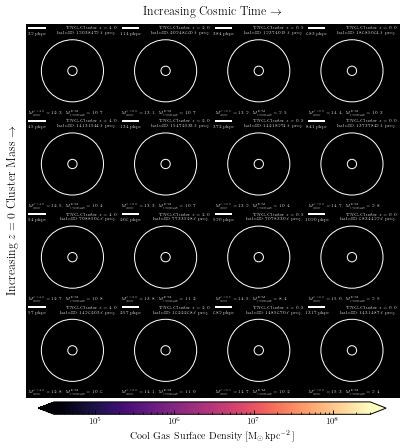

In [13]:
fig, ax = plot_coolgasmap_mosaic(TNGCluster_grp_dict, TNGCluster_tau_dict)

if savefig:
    fname = '%s_CoolGasSurfaceDensityMapsMosaic_m200c_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', dpi=300)
        

/tmp/ipykernel_72942/2135894185.py:135: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


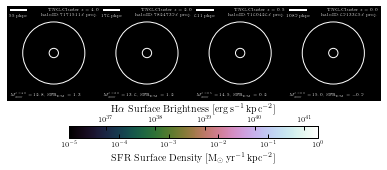

In [14]:
fig, ax = plot_sfrmap_4panel(TNGCluster_grp_dict, TNGCluster_tau_dict, halpha_label=True)
if savefig:
    fname = '%s_SFRSurfaceDensityMap_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', dpi=300)
        

/tmp/ipykernel_72942/2135894185.py:92: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


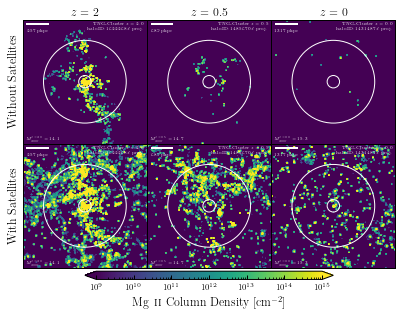

In [15]:
fig, ax = plot_mgiicoldens_comparison(TNGCluster_grp_dict, grp_keys[4])
if savefig:
    fname = '%s_MgiiColDensComparison_evolution.pdf'%sim
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight', dpi=300)

In [16]:
def model_2dradprof(data):
    """ 
    compute the model 2D radial profile from a 2D histogram
    based on StackOverflow answer found here: 
    https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile
    """
    center = [(data.shape[0] - 1.) / 2., (data.shape[1] - 1.) / 2.]
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    
    rpix = np.arange(radialprofile.size)
    radprof_func = interpolate.interp1d(rpix, radialprofile)
    
    model = radprof_func(r)
    
    return model, radprof_func 

In [17]:
radii_bincents = np.logspace(np.log10(1.0e-2), np.log10(1.5)) # R200c
radii_mgii_key = 'radii_mgii'
mgiimap_keys = [mgiimap_depthvel_key, mgiimap_depthvel_sats_key, mgiimap_depthdist_key]
mgii_coldens_depthvel_radprof_key = 'MgiiColDens_depth2000kms_RadProf'
mgii_coldens_depthvel_sats_radprof_key = 'MgiiColDens_depth2000kms_WITHSATELLITES_RadProf'
mgii_coldens_depthdist_radprof_key = 'MgiiColDens_depth1.5R200c_RadProf'

mgiiradprof_keys = [mgii_coldens_depthvel_radprof_key, mgii_coldens_depthvel_sats_radprof_key, mgii_coldens_depthdist_radprof_key]

snapNums = [99, 67, 33]

for grp_key in TNGCluster_grp_dict_keys:
    group = TNGCluster_grp_dict[grp_key]
    for radprof_key in mgiiradprof_keys:
        group[radprof_key] = np.zeros((len(snapNums), len(radii_bincents)), dtype=float) - 1.
    group[radii_mgii_key] = group[radprof_key].copy()
    for snapNum_i, snapNum in enumerate(snapNums):
        time_index = np.where(group['SnapNum'] == snapNum)[0][0]
        for mgiimap_key_i, mgiimap_key in enumerate(mgiimap_keys):
            data = group[mgiimap_key][time_index]
            _, radprof_func = model_2dradprof(data)
            group[mgiiradprof_keys[mgiimap_key_i]][time_index][:] = radprof_func(radii_bincents * data.shape[0] / 3.)
            group[radii_mgii_key][time_index][:] = radii_bincents * group['HostGroup_R_Crit200'][time_index]

In [18]:
grp_dict = TNGCluster_grp_dict
grp_dict_keys = TNGCluster_grp_dict_keys
tau_dict = TNGCluster_tau_dict

In [19]:
redshifts = [0.0, 0.5, 2.0]
snapNums = [99, 67, 33]
colors = ['k', 'tab:purple', 'tab:orange']
redshift_ticklabels = ['0', '0.5', '2']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom_since2', colors)
bounds = np.linspace(-0.5, 2.5, len(redshifts)+1)
bounds = np.array([-0.25, 0.25, 0.75, 3.25])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=cmap_norm)
sm.set_array([])

plot_kwargs = dict(marker='o', fillstyle='none', ms=2, mew=1.0, alpha=0.5)
med_kwargs = dict(marker='None', ls='-', lw=2, path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()], zorder=3)
hist_kwargs = dict(lw=0.1, alpha=0.2, ls='-', cmap=cmap, norm=cmap_norm)
percentiles_kwargs = dict(alpha=0.5)

stacked_profiles_kwargs_depth = med_kwargs.copy()
stacked_profiles_kwargs_depth['ls'] = '--'
stacked_profiles_kwargs_depth['zorder'] = 1.9

all_profiles_kwargs_depth = dict(alpha=0)

M200c_log = np.log10(tau_dict['HostGroup_M_Crit200_snapNum099'])
mask = ((M200c_log > 14.95) * (M200c_log < 15.05))
tau_dict_m200cz015_indices = np.where(mask)[0]
SubfindIDs = tau_dict['SubfindID'][mask]
grp_dict_keys_M200cz015 = []
for subfindID in SubfindIDs:
    grp_dict_keys_M200cz015.append('099_%08d'%subfindID)

maskdset_key = 'HostGroup_M_Crit200_snapNum067'
maskdset_bincents = [14, 14.5, 15.0]
maskdset_binwidths = [0.2, 0.1, 0.2]
cdset_key = 'HostGroup_M_Crit200'

cmap_mass = 'viridis_r'
cmap_mass_norm = mpl.colors.Normalize(vmin=13.75, vmax=15.25)
all_profiles_kwargs = dict(cmap=cmap_mass, norm=cmap_mass_norm, linewidths=0.1, alpha=0.2)
stacked_profiles_kwargs = dict(cmap=cmap_mass, norm=cmap_mass_norm, linewidths=2, 
                               path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()])

def add_stacked_hist_dict(ax, grp_dict, grp_dict_keys, redshifts=redshifts,
                          bincents_key='CGMTemperaturesHistogramBincents', dset_key='CGMTemperaturesHistogram',
                          colors=colors, radii_norm='HostGroup_R_Crit200',
                          return_color_dset='Redshift', color_dset_log=False, return_result=False,
                          stacked_profiles_kwargs=med_kwargs, all_profiles_kwargs=hist_kwargs):
    """
    For a given histogram quantity, such as gas temperature PDF or gas density, and the bincents, compute the 
    quantity for all grp_dict_keys, and compute the median. Additionally includes some extra plotting keywords.
    Plots both the individual histograms and the median stack. Returns ax and the LineCollection 
    """

    result = {}
    for redshift_i, redshift in enumerate(redshifts):
        result[redshift] = {}
        stacked_dict, bincents, hists, color = return_stacked_hist_dict(grp_dict, grp_dict_keys, return_all_profiles=True,
                                                                        dset_key=dset_key, bincents_key=bincents_key,
                                                                        redshifts=redshifts, redshift_index=redshift_i,
                                                                        return_color_dset=return_color_dset, radii_norm=radii_norm,
                                                                        color_dset_log=color_dset_log)
        result[redshift]['stacked_dict'] = stacked_dict
        result[redshift]['bincents'] = bincents
        result[redshift]['hists'] = hists
        result[redshift]['color'] = color
        result[redshift]['stacked_dict_kwargs'] = stacked_profiles_kwargs.copy()
        result[redshift]['stacked_dict_kwargs']['c'] = colors[redshift_i]
        result[redshift]['norm_kwargs'] = all_profiles_kwargs.copy()

    for redshift_i, redshift in enumerate(redshifts[::-1]):
        _result = result[redshift]
        time_index = np.argmin(np.abs(grp_dict[grp_dict_keys[0]]['Redshift'] - redshift))

        y = _result['stacked_dict']['50']
        x = _result['stacked_dict']['bincents']
        if 'Mass' in dset_key or 'RadProf' in dset_key:
            mask = y > 0
        else: 
            mask = x > 0
        ax.plot(x[mask], y[mask], **_result['stacked_dict_kwargs'])

        _hists = _result['hists']
        _bincents = _result['bincents']
        ys = []
        xs = []
        cs = []
        for y_i, y in enumerate(_hists):
            if grp_dict[grp_dict_keys[y_i]]['SubfindID'][time_index] < 0:
                continue
            if 'Mass' in dset_key or 'RadProf' in dset_key:
                mask = y > 0
            else: 
                mask = x > 0
            x = _bincents[y_i][mask]
            xs.append(x)
            ys.append(y[mask])
            cs.append(_result['color'][y_i])

        if not norm:
            vmin = np.percentile(cs, 5)
            vmax = np.percentile(cs, 95)
            if color_dset_log:
                _result['norm_kwargs']['norm'] = mpl.colors.Normalize(vmin, vmax)
            else:
                _result['norm_kwargs']['norm'] = mpl.colors.LogNorm(vmin, vmax)
        
        lc = ru.multiline(xs, ys, cs, ax=ax, **_result['norm_kwargs'])
    if return_result:
        return ax, lc, result
    
    return ax, lc


def return_stacked_hist_dict(grp_dict, grp_dict_keys, dset_key='CGMTemperaturesHistogram', bincents_key='CGMTemperaturesHistogramBincents', radii_norm='HostGroup_R_Crit200',
                             redshifts=[0.], redshift_index=0, return_all_profiles=False, return_color_dset=False, color_dset_log=False):
    """
    For a histogram quantity, such as gas temperature PDF or gas density radial profile, and the associated bincents,
    compute the histogram for all grp_dict_keys and the median for this sample. 
    """

    if not isinstance(redshifts, (list, tuple, np.ndarray)):
        redshifts = [redshifts]
    if redshift_index >= len(redshifts):
        raise ValueError('redshift_index %d >= len(redshifts) %d'%(redshift_index, len(redshifts)))

    redshift = redshifts[redshift_index]
        
    result_dict = {}
 
    # initalize the outputs
    _bincents = np.zeros((len(grp_dict_keys), len(grp_dict[grp_dict_keys[0]][bincents_key][0])), dtype=float) - 1   
    _hists = _bincents.copy() 

    if return_color_dset:
        if return_color_dset in grp_dict[grp_dict_keys[0]].keys():
            color_dset = np.zeros(len(grp_dict_keys), dtype=grp_dict[grp_dict_keys[0]][return_color_dset].dtype) - 1
        else:
            print('return_color_dset %s not recognized. Please choose from the following'%return_color_dset)
            print(grp_dict[grp_dict_keys[0]].keys())
            raise KeyError()

    for index, grp_dict_key in enumerate(grp_dict_keys):
        group = grp_dict[grp_dict_key]
        time_index = np.argmin(abs(group['Redshift'] - redshift))
        if group['SubfindID'][time_index] < 0:
            continue
        if return_color_dset:
            if color_dset_log:
                color_dset[index] = np.log10(group[return_color_dset][time_index])
            else:
                color_dset[index] = group[return_color_dset][time_index]
        _bincents[index,:] = group[bincents_key][time_index]
        _hist = group[dset_key][time_index]
        if np.sum(_hist) <= 0:
            continue
        elif 'RadProf' in dset_key:
            result = clean_radprof(group, dset_key, time_index, radii_key=bincents_key, norm=radii_norm)
            _bincents[index,:] = result[0]
            _hists[index,:] = result[1]

    # finish loop of indices, save final results
    bincents = np.ma.masked_values(_bincents, -1)
    hists = np.ma.masked_values(_hists, -1)

    result_dict['50'] = np.median(hists, axis=0)
    result_dict['16'] = np.percentile(hists, 16, axis=0)
    result_dict['84'] = np.percentile(hists, 84, axis=0) 
    result_dict['Ngal'] = len(hists)
    result_dict['bincents'] = np.median(bincents, axis=0)
    
    if return_all_profiles:
        if return_color_dset:
            return result_dict, bincents, hists, color_dset
        else:
            return result_dict, bincents, hists
    else:
        if return_color_dset:
            return result_dict, color_dset
        else:
            return result_dict


def clean_radprof(group, dset_key, time_index,
                  norm='HostGroup_R_Crit200', radii_key='radii'):
    """
    Clean the cooling and free fall radial profiles
    """

    _radii = group[radii_key][time_index].copy()
    _dset = group[dset_key][time_index].copy()
    mask = _dset > 0

    #dset[mask] = -1.

    if mask[mask].size < 2:
        return _radii, np.zeros(_dset.size, dtype=_dset.dtype) + 1.0e10

    dset_func = interp1d(_radii[mask], _dset[mask], bounds_error=False, fill_value=-1.)
    dset = dset_func(_radii)

    if norm:
        rnorm = group[norm][time_index]
    else:
        rnorm = 1.

    radii = _radii / rnorm

    sigma = 2
    radii = ndimage.gaussian_filter1d(radii, sigma)
    dset = ndimage.gaussian_filter1d(dset, sigma)

    return radii, dset


def plot_stacked_dict_masstrend(ax, plot_result,
                                all_profiles_kwargs=all_profiles_kwargs, stacked_profiles_kwargs=stacked_profiles_kwargs):
    """
    plot all and stacked profiles from plot_result to ax
    """

    lc = ru.multiline(plot_result['all_profiles']['xs'], plot_result['all_profiles']['ys'], plot_result['all_profiles']['cs'],
                    ax=ax, **all_profiles_kwargs)

    xs = []
    ys = []
    cs = []
    for bincent in plot_result['stacked_profiles']:
        result_dict = plot_result['stacked_profiles'][bincent]
        xs.append(result_dict['bincents'])
        ys.append(result_dict['50'])
        cs.append(float(bincent))

    lc = ru.multiline(xs, ys, cs, ax=ax, **stacked_profiles_kwargs)

    return ax, lc



def return_stacked_dict_masstrend(grp_dict=grp_dict, grp_dict_keys=grp_dict_keys, tau_dict=tau_dict, redshifts=[0.],
                                  maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths,
                                  xdset_key=radii_mgii_key, ydset_key=mgii_coldens_depthvel_radprof_key, cdset_key=cdset_key, color_dset_log=True, radii_norm='HostGroup_R_Crit200'):
    """ 
    Compute the evolution of ydset_key as a function of xdset_key, and compute the median evolution trend based on
    the maskdset. Returns a dictionary plot_result which contains the necessary profiles to plot via ru.multiline()
    both all profiles and the median trends. 
    """

    plot_result = dict(all_profiles=dict(), stacked_profiles=dict())

    # compute all profiles and the scalar for the color
    _, bincents, hists, color = return_stacked_hist_dict(grp_dict, grp_dict_keys, dset_key=ydset_key, bincents_key=xdset_key,
                                                        redshifts=redshifts, redshift_index=0, return_all_profiles=True,
                                                        return_color_dset=cdset_key, color_dset_log=color_dset_log, radii_norm=radii_norm)
    xs = []
    ys = []
    cs = []
    for row in np.arange(hists.shape[0]):
        xs.append(bincents[row])
        ys.append(hists[row])
        cs.append(color[row])

    plot_result['all_profiles'] = dict(xs=xs, ys=ys, cs=cs, Ngal=len(xs))

    # for each of the mass bins of interest, compute the median
    SubfindIDz0 = tau_dict['SubfindID']

    maskdset = tau_dict[maskdset_key]

    xs = []
    ys = []
    cs = []
    for bincent_i, bincent in enumerate(maskdset_bincents):
        maskdset_binwidth = maskdset_binwidths[bincent_i]
        maskdset_lolim = 10.**(bincent - maskdset_binwidth/2.)
        maskdset_hilim = 10.**(bincent + maskdset_binwidth/2.)

        indices = np.where((maskdset > maskdset_lolim) & (maskdset < maskdset_hilim))[0]

        grp_dict_keys = []
        for index in indices:
            grp_dict_keys.append('099_%08d'%SubfindIDz0[index])

        result_dict = return_stacked_hist_dict(grp_dict, grp_dict_keys, dset_key=ydset_key, bincents_key=xdset_key, radii_norm=radii_norm,
                                               redshifts=redshifts, redshift_index=0, return_all_profiles=False, return_color_dset=False, color_dset_log=False)

        
        plot_result['stacked_profiles'][bincent] = result_dict
    
    return plot_result


def add_r200c_mark_masstrend(ax, textkwargs=dict(fontsize='small', color='k'),
                             tau_dict=tau_dict, maskdset_log=True, colors=None, cdset_key='HostGroup_R_Crit200_snapNum067',
                             maskdset_key='HostGroup_M_Crit200_snapNum067', maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths):
    
    assert len(colors) == len(maskdset_bincents) == len(maskdset_binwidths), 'Inputs are of unequal lengths'

    dset = tau_dict[maskdset_key]
    if maskdset_log:
        dset = np.log10(dset)

    r200cs = np.zeros(len(maskdset_bincents), dtype=float) - 1
    for maskdset_bincent_i, maskdset_bincent in enumerate(maskdset_bincents):
        maskdset_binwidth = maskdset_binwidths[maskdset_bincent_i]
        indices = np.abs(dset - maskdset_bincent) < (maskdset_binwidth / 2.)
        r200cs[maskdset_bincent_i] = np.median(tau_dict[cdset_key][indices])

    for r200c_i, r200c in enumerate(r200cs):
        kwargs = dict(ymax=0.7, ymin=0.6, marker='None', lw=2, color=colors[r200c_i], zorder=3.1)
        ax.axvline(r200c, ls='-', **kwargs)
        # for the 0th index, include the text label
        if r200c_i == 0:
            ax.text(r200c * 1.1, (kwargs['ymax'] + kwargs['ymin'])/2., r'$R_{\rm 200c}$', 
                    rotation=270, ha='left', va='center', transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), **textkwargs)
    return ax
    


In [41]:
def add_observational_data(ax, kwargs=None, mass_color=False):
    if not kwargs:
        kwargs = dict(ms=10, alpha=0.75, zorder=1.9, mec='k', mew=1.0)

    if mass_color:
        fresco_c = 'tab:purple'
        anand_c = mishra_c = 'chartreuse'
    else:
        fresco_c = anand_c = mishra_c = 'tab:purple'
    
    ax.plot(Fresco_24_bd_x, 10.**(Fresco_24_bd_y), marker='o', c=fresco_c, **kwargs)
    ax.plot(Anand_22_Clusters_x, 10.**(Anand_22_Clusters_y), marker='^', c=anand_c,  **kwargs)
    #ax.plot(Anand_22_LRGs_x, 10.**(Anand_22_LRGs_y), marker='^', **kwargs)
    #ax.plot(LanMo_18_LRGs_x, 10.**(LanMo_18_LRGs_y), marker='v', **kwargs)
    ax.plot(Mishra_22_x, 10.**(Mishra_22_y), marker='s', **kwargs, c=mishra_c)

    ax.plot([], [], marker='o', c='k', **kwargs, label=r'Fresco+24')
    ax.plot([], [], marker='^', c='k',  **kwargs, label=r'Anand+22')
    ax.plot([], [], marker='s', **kwargs, c='k', label=r'Mishra+22')

    return ax


Anand_22_Clusters_x = np.array([81.64,
                       188.95,
                       327.68,
                       505.12,
                       731.82,
                       877.74,
                       1074.32,
                       1262.15,
                       1456.92,
                       1627.50, 
                       1839.74,
                       2413.14,
                       3307.39,
                       4561.30,
                       5807.24])

Anand_22_Clusters_y = np.array([12.51,
                       12.11,
                       12.08,
                       11.90,
                       11.89,
                       11.89,
                       11.64,
                       11.66,
                       11.63,
                       11.55,
                       11.53,
                       11.55,
                       11.52,
                       11.45,
                       11.45])

Anand_22_LRGs_x = np.array([45.66667909451797,
                            115.46347093182747,
                            213.14114760334834,
                            351.4263123796326,
                            502.5236046041354,
                            624.9939111885839,
                            770.4661190316178,
                            909.6693639681046,
                            1053.7846428006928,
                            1199.1017588267164,
                            1327.4281531726954,
                            1729.2637982031076,
                            2382.9361208677688,
                            3301.8961922165568,
                            4124.175009470496,
                            4905.883424368378])

Anand_22_LRGs_y = np.array([12.138478758818206,
                          11.820130821462076,
                          11.66181717023941,
                          11.56022570886594,
                          11.572314450905274,
                          11.497397931983585,
                          11.43912132032351,
                          11.39128707572395,
                          11.401039019138658,
                          11.371033099007732,
                          11.3870035045522,
                          11.338746172061942,
                          11.32099921064921,
                          11.291971971847866,
                          11.289346140653219,
                          11.28190361654909])

LanMo_18_LRGs_x = np.array([22.369944557938815,
                            34.97989077185501, 
                            47.75080725080265, 
                            67.77069328512495,
                            93.1449533888376, 
                            133.53474435328545,
                            188.27218928288988,
                            265.0129496167316, 
                            374.27936964164917,
                            518.7702608541491, 
                            729.2287922662381, 
                            1043.0361216475555])

LanMo_18_LRGs_y = np.array([12.807779522132817,
                            12.739511139764682,
                            12.819458220199941,
                            12.549472870715912,
                            12.626758862632299,
                            12.262890491009253,
                            12.148712552330652,
                            12.101529212178319,
                            11.8618233176703,
                            11.749612298581235,
                            11.550795859834443,
                            11.333007364518888])

Fresco_24_bd_x = np.array([1630.250963146094])
Fresco_24_bd_y = np.array([12.12172416839208])

Mishra_22_x = np.array([1.4925934775679317, 
                        2.3992422322981204,
                        3.142768886980761]) * 1.0e3
Mishra_22_y = np.array([11.22294239708365,
                        11.074270595910688,
                        11.113968111996316])

def add_r200c_mark_evolution(ax, norm='phys', textkwargs=dict(fontsize='small', color='k'),
                             grp_dict=None, grp_dict_keys=None, redshifts=None, colors=None):

    igm_xval = 1.0

    # input validations
    if not isinstance(grp_dict_keys, list):
        grp_dict_keys = [grp_dict_keys]
    assert len(redshifts) == len(colors), KeyError('len(redshifts) != len(colors)')
    for redshift_i, redshift in enumerate(redshifts):
        rmaxs = np.zeros(len(grp_dict_keys), dtype=float) - 1.

        for grp_dict_key_i, grp_dict_key in enumerate(grp_dict_keys):
            group = grp_dict[grp_dict_key]
            redshift_index = np.argmin(abs(group['Redshift'] - redshift))
            r200c = group['HostGroup_R_Crit200'][redshift_index]
            if norm == 'rhalfstar':
                rhalfstar = group['Subhalo_Rgal'][redshift_index] / 2.0
                rmaxs[grp_dict_key_i] = igm_xval * r200c / rhalfstar
            else:
                rmaxs[grp_dict_key_i] = igm_xval * r200c

        # finish loop over grp_dict_keys
        xmax = np.median(rmaxs)

        kwargs = dict(ymax=0.7, ymin=0.6, marker='None', lw=2, color=colors[redshift_i], zorder=3.1)
        ax.axvline(xmax, ls='-', **kwargs)
        # for redshift = 0, include the text label
        if redshift_i == 0:
            ax.text(xmax * 1.1, (kwargs['ymax'] + kwargs['ymin'])/2., r'$R_{\rm 200c}$', 
                    rotation=270, ha='left', va='center', transform=transforms.blended_transform_factory(ax.transData, ax.transAxes), **textkwargs)
    
    return ax




    


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2021.11/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


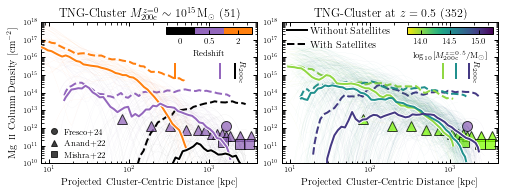

In [43]:
label_fontisze = 'small'
radii_norm = None
fig, axs = plt.subplots(1, 2, figsize=(figsizewidth, figsizeheight * 0.67))

add_satellites = True
add_obs = True

ax = axs[0]
redshifts = [0.0, 0.5, 2.0]
snapNums = [99, 67, 33]
colors = ['k', 'tab:purple', 'tab:orange']
redshift_ticklabels = ['0', '0.5', '2']
cmap = mpl.colors.LinearSegmentedColormap.from_list('Redshift_custom_since2', colors)
bounds = np.linspace(-0.5, 2.5, len(redshifts)+1)
bounds = np.array([-0.25, 0.25, 0.75, 3.25])
cmap_norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=cmap_norm)
sm.set_array([])

plot_kwargs = dict(marker='o', fillstyle='none', ms=2, mew=1.0, alpha=0.5)
med_kwargs = dict(marker='None', ls='-', lw=2, path_effects=[pe.Stroke(linewidth=4, foreground='white'), pe.Normal()], zorder=3)
hist_kwargs = dict(lw=0.1, alpha=0.2, ls='-', cmap=cmap, norm=cmap_norm)
percentiles_kwargs = dict(alpha=0.5)

stacked_profiles_kwargs_depth = med_kwargs.copy()
stacked_profiles_kwargs_depth['ls'] = '--'
stacked_profiles_kwargs_depth['zorder'] = 1.9

all_profiles_kwargs_depth = dict(alpha=0)

ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys_M200cz015, redshifts=redshifts,
                               bincents_key=radii_mgii_key, dset_key=mgii_coldens_depthvel_radprof_key,
                               colors=colors, radii_norm=radii_norm)

cax = inset_axes(ax, width='40%', height='5%', loc='upper right')
cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
cbar.set_label(r'Redshift', fontsize=label_fontisze)
cbar.ax.tick_params(labelsize='small')
cbar.set_ticks(redshifts)
cbar.set_ticklabels(['0', '0.5', '2'])
cax.xaxis.set_label_position('bottom')
cax.xaxis.set_ticks_position('bottom')
cbar.ax.minorticks_off()
cbar.solids.set(alpha=1.0)

if add_satellites:
    ax, lc = add_stacked_hist_dict(ax, grp_dict, grp_dict_keys_M200cz015, redshifts=redshifts,
                                bincents_key=radii_mgii_key, dset_key=mgii_coldens_depthvel_sats_radprof_key,
                                colors=colors, radii_norm=radii_norm,
                                stacked_profiles_kwargs=stacked_profiles_kwargs_depth, all_profiles_kwargs=all_profiles_kwargs_depth)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1.0e10, 1.0e18)
ax.set_ylabel(r'Mg\, {\sc ii} Column Density $[{\rm cm^{-2}}]$')
ax.set_title(r'TNG-Cluster $M_{\rm 200c}^{z=0} \sim 10^{15}\, {\rm M_\odot}$ (%d)'%len(grp_dict_keys_M200cz015))
ax.set_xlim(8, 4.0e3)
ax.set_xlabel(r'Projected Cluster-Centric Distance [kpc]')

if add_obs:
    ax = add_observational_data(ax, mass_color=False)
ax.legend(loc='lower left', fontsize='small', markerscale=0.6)

ax = add_r200c_mark_evolution(ax, norm='phys', grp_dict=grp_dict, grp_dict_keys=grp_dict_keys_M200cz015, redshifts=redshifts, colors=colors)


ax = axs[1]

maskdset_key = 'HostGroup_M_Crit200_snapNum067'
maskdset_bincents = [14, 14.5, 15.0]
maskdset_binwidths = [0.2, 0.1, 0.2]
cdset_key = 'HostGroup_M_Crit200'

stacked_profiles_kwargs_depth = stacked_profiles_kwargs.copy()
stacked_profiles_kwargs_depth['ls'] = '--'
stacked_profiles_kwargs_depth['zorder'] = 1.9

all_profiles_kwargs_depth = dict(alpha=0)

plot_result = return_stacked_dict_masstrend(grp_dict, grp_dict_keys, tau_dict, redshifts=[0.5],
                                            xdset_key=radii_mgii_key, ydset_key=mgii_coldens_depthvel_radprof_key, radii_norm=radii_norm,
                                            maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths)
ax, lc = plot_stacked_dict_masstrend(ax, plot_result, all_profiles_kwargs=all_profiles_kwargs, stacked_profiles_kwargs=stacked_profiles_kwargs)


_cmap = lc.get_cmap()
_vmin, _vmax = lc.get_clim()
maskdset_bincents = np.array(maskdset_bincents[::-1])
_vals = (maskdset_bincents - _vmin) / (_vmax - _vmin)
_colors = _cmap(_vals)

ax = add_r200c_mark_masstrend(ax, maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths[::-1],
                              colors=_colors)

cax = inset_axes(ax, width='40%', height='5%', loc='upper right')
cbar = plt.colorbar(lc, cax=cax, orientation='horizontal')
cbar.set_label(r'$\log_{10}[M_{\rm 200c}^{z=0.5} / {\rm M_\odot}]$', fontsize=label_fontisze)
cbar.ax.tick_params(labelsize='small')
cbar.set_ticks(maskdset_bincents)
cax.xaxis.set_label_position('bottom')
cax.xaxis.set_ticks_position('bottom')
cbar.ax.minorticks_off()

if add_satellites:
    plot_result = return_stacked_dict_masstrend(grp_dict, grp_dict_keys, tau_dict, redshifts=[0.5],
                                                xdset_key=radii_mgii_key, ydset_key=mgii_coldens_depthvel_sats_radprof_key, radii_norm=radii_norm,
                                                maskdset_key=maskdset_key, maskdset_bincents=maskdset_bincents, maskdset_binwidths=maskdset_binwidths)
    ax, lc = plot_stacked_dict_masstrend(ax, plot_result, all_profiles_kwargs=all_profiles_kwargs_depth, stacked_profiles_kwargs=stacked_profiles_kwargs_depth)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(axs[0].get_ylim())
ax.set_xlim(axs[0].get_xlim())
ax.set_xlabel(axs[0].get_xlabel())
ax.set_title(r'TNG-Cluster at $z=0.5$ (%d)'%len(grp_dict_keys))

ax.plot([], [], ls='-', lw=2, c='k', marker='None', label=r'Without Satellites')
if add_satellites:
    ax.plot([], [], ls='--', lw=2, c='k', marker='None', label=r'With Satellites')
ax.legend(loc='upper left')

if add_obs:
    ax = add_observational_data(ax, mass_color=True)

if savefig:
    fname = 'TNG-Cluster_MgiiColDensRadProf_multipanel.pdf'
    for outdirec in outdirecs:
        fig.savefig(outdirec + fname, bbox_inches='tight')